## 공통 모듈 import 설정

In [18]:
# 실험 전역 설정 및 공통 유틸 불러오기
import torch                
import pandas as pd
import matplotlib.pyplot as plt
import os

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    
import cifar_common
from cifar_common import (
    device,
    set_seed,
    create_cifar10_loaders,
    create_resnet18_cifar,
    create_vit_model,
    train_one_epoch,
    evaluate,
)

print("Using device:", device)
set_seed(42)  # 모든 실험을 같은 난수 상태에서 시작하도록 고정


Using device: cuda


## 데이터/모델 확인

In [19]:
# CNN DataLoader Test
# CNN 기준 DataLoader를 만들어 배치 구성과 크기가 의도대로 나오는지 점검
train_loader_cnn, test_loader_cnn = create_cifar10_loaders(
    data_ratio=1.0,
    for_vit=False,
    batch_size=128,
)
print("Train size (CNN):", len(train_loader_cnn.dataset))
print("Test size:", len(test_loader_cnn.dataset))

images, labels = next(iter(train_loader_cnn))
print("Batch images shape:", images.shape)
print("Batch labels shape:", labels.shape)

# 모델 파라미터 수를 확인해 용량(capacity) 차이를 파악
cnn_temp = create_resnet18_cifar(num_classes=10, pretrained=False).to(device)
print("CNN params (M):", sum(p.numel() for p in cnn_temp.parameters()) / 1e6)

if cifar_common.timm is not None:
    vit_temp = create_vit_model(
        model_name="vit_tiny_patch16_224",
        num_classes=10,
        pretrained=True,
    ).to(device)
    print("ViT params (M):", sum(p.numel() for p in vit_temp.parameters()) / 1e6)


Files already downloaded and verified
Files already downloaded and verified
Train size (CNN): 50000
Test size: 10000
Batch images shape: torch.Size([128, 3, 32, 32])
Batch labels shape: torch.Size([128])
CNN params (M): 11.181642
ViT params (M): 5.526346


## baseline 실험 공통 함수

In [20]:
# 변경 스니펫: run_baseline_experiment가 model까지 반환하도록 수정

def run_baseline_experiment(
    model_type: str,
    num_epochs: int,
    data_ratio: float = 1.0,
):
    assert model_type in ["cnn", "vit"]

    set_seed(42)

    if model_type == "cnn":
        for_vit = False
        batch_size = 128
    else:
        for_vit = True
        batch_size = 64  # ViT는 입력 해상도 때문에 배치 크기를 줄여서 학습

    # 모델 유형에 맞춰 DataLoader(전처리 포함) 준비
    train_loader, test_loader = create_cifar10_loaders(
        data_ratio=data_ratio,
        for_vit=for_vit,
        batch_size=batch_size,
    )

    # CNN / ViT별 손실함수와 optimizer 설정
    if model_type == "cnn":
        model = create_resnet18_cifar(num_classes=10, pretrained=False).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4,
        )
    else:
        if cifar_common.timm is None:
            raise RuntimeError("timm이 설치되어 있지 않아 ViT를 사용할 수 없습니다.")
        model = create_vit_model(
            model_name="vit_tiny_patch16_224",
            num_classes=10,
            pretrained=True,
        ).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=3e-4,
            weight_decay=0.05,
        )

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    best_test_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        # 한 epoch 학습/평가 결과를 기록해서 나중에 곡선으로 확인
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        test_loss, test_acc = evaluate(
            model, test_loader, criterion, device
        )

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc

        print(
            f"[{model_type.upper()}][Epoch {epoch}/{num_epochs}] "
            f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}"
        )

    print(f"\n[{model_type.upper()}] num_epochs={num_epochs} 기준 best test acc = {best_test_acc:.4f}\n")

    return model, history, best_test_acc


## epoch 리스트 별로 CNN / ViT 실행

In [21]:
baseline_root = "results/baseline"
ensure_dir(f"{baseline_root}/cnn")
ensure_dir(f"{baseline_root}/vit")

# 비교하고 싶은 epoch 조합 정의
epoch_list = [5, 10, 20]

results_summary = []
cnn_histories = {}
vit_histories = {}

# CNN 학습 및 결과 저장
for n_epochs in epoch_list:
    model_cnn, history_cnn, best_acc_cnn = run_baseline_experiment(
        model_type="cnn",
        num_epochs=n_epochs,
        data_ratio=1.0,
    )

    cnn_histories[n_epochs] = history_cnn

    pd.DataFrame(history_cnn).to_csv(
        f"{baseline_root}/cnn/cnn_epochs_{n_epochs}.csv", index=False
    )
    torch.save(
        model_cnn.state_dict(),
        f"{baseline_root}/cnn/cnn_epochs_{n_epochs}.pth"
    )

    results_summary.append({
        "model": "cnn",
        "num_epochs": n_epochs,
        "best_test_acc": best_acc_cnn,
    })

# timm이 있을 때만 ViT 비교 수행
if cifar_common.timm is not None:
    for n_epochs in epoch_list:
        model_vit, history_vit, best_acc_vit = run_baseline_experiment(
            model_type="vit",
            num_epochs=n_epochs,
            data_ratio=1.0,
        )

        vit_histories[n_epochs] = history_vit

        pd.DataFrame(history_vit).to_csv(
            f"{baseline_root}/vit/vit_epochs_{n_epochs}.csv", index=False
        )
        torch.save(
            model_vit.state_dict(),
            f"{baseline_root}/vit/vit_epochs_{n_epochs}.pth"
        )

        results_summary.append({
            "model": "vit",
            "num_epochs": n_epochs,
            "best_test_acc": best_acc_vit,
        })

# 한눈에 비교하기 위한 요약 테이블

df_summary = pd.DataFrame(results_summary)
df_summary = df_summary.sort_values(by=["model", "num_epochs"]).reset_index(drop=True)
df_summary


Files already downloaded and verified
Files already downloaded and verified
[CNN][Epoch 1/5] train_loss=1.6958, train_acc=0.3871, test_loss=1.3806, test_acc=0.4969
[CNN][Epoch 2/5] train_loss=1.3543, train_acc=0.5135, test_loss=1.1533, test_acc=0.5855
[CNN][Epoch 3/5] train_loss=1.1685, train_acc=0.5822, test_loss=1.0635, test_acc=0.6349
[CNN][Epoch 4/5] train_loss=1.0539, train_acc=0.6255, test_loss=0.9856, test_acc=0.6605
[CNN][Epoch 5/5] train_loss=0.9660, train_acc=0.6591, test_loss=0.9024, test_acc=0.6853

[CNN] num_epochs=5 기준 best test acc = 0.6853

Files already downloaded and verified
Files already downloaded and verified
[CNN][Epoch 1/10] train_loss=1.6958, train_acc=0.3871, test_loss=1.3806, test_acc=0.4969
[CNN][Epoch 2/10] train_loss=1.3543, train_acc=0.5135, test_loss=1.1533, test_acc=0.5855
[CNN][Epoch 3/10] train_loss=1.1685, train_acc=0.5822, test_loss=1.0635, test_acc=0.6349
[CNN][Epoch 4/10] train_loss=1.0539, train_acc=0.6255, test_loss=0.9856, test_acc=0.6605
[CNN]

,model,num_epochs,best_test_acc
0,cnn,5,0.6853
1,cnn,10,0.7346
2,cnn,20,0.7865
3,vit,5,0.9242
4,vit,10,0.9322
5,vit,20,0.9396


## 특정 에폭에 대해 CNN vs ViT 학습 곡선 시각화

In [22]:
print(cnn_histories.keys())


dict_keys([5, 10, 20])


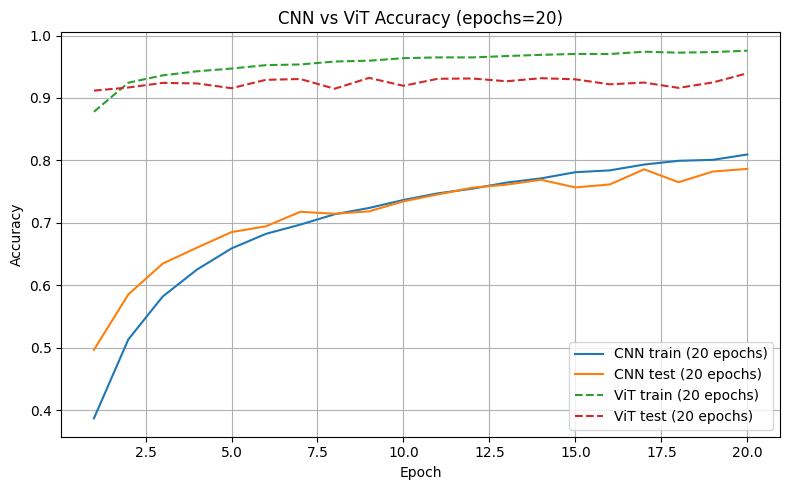

In [23]:
# 시각화 대상 에폭 수 
target_epochs = max(epoch_list)

# CNN / ViT 기록 가져오기
hist_cnn = cnn_histories[target_epochs]
hist_vit = vit_histories.get(target_epochs, None)

plt.figure(figsize=(8, 5))

# 학습/검증 정확도 궤적을 한 그래프에 표시
def plot_history(hist, label_prefix, style_kwargs=None):
    style_kwargs = style_kwargs or {}
    plt.plot(hist["epoch"], hist["train_acc"], label=f"{label_prefix} train", **style_kwargs)
    plt.plot(hist["epoch"], hist["test_acc"], label=f"{label_prefix} test", **style_kwargs)

plot_history(hist_cnn, f"CNN ({target_epochs} epochs)")

if hist_vit is not None:
    plot_history(
        hist_vit,
        f"ViT ({target_epochs} epochs)",
        style_kwargs={"linestyle": "--"}
    )

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"CNN vs ViT Accuracy (epochs={target_epochs})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 에폭별 CNN vs ViT 최종 성능 비교

In [24]:
print("에폭 수별 CNN vs ViT 최종 정확도 비교\n")

# 보고서용 텍스트 요약
for n in sorted(epoch_list):
    row_cnn = df_summary[(df_summary["model"] == "cnn") & (df_summary["num_epochs"] == n)]
    row_vit = df_summary[(df_summary["model"] == "vit") & (df_summary["num_epochs"] == n)]

    cnn_acc = float(row_cnn["best_test_acc"].values[0]) if not row_cnn.empty else None
    vit_acc = float(row_vit["best_test_acc"].values[0]) if not row_vit.empty else None

    print(f"[epochs={n}]")
    if cnn_acc is not None:
        print(f"  CNN : {cnn_acc:.4f}")
    else:
        print("  CNN : 결과 없음")

    if vit_acc is not None:
        print(f"  ViT : {vit_acc:.4f}")
    else:
        print("  ViT : 결과 없음")

    if cnn_acc is not None and vit_acc is not None:
        print(f"  ViT - CNN : {vit_acc - cnn_acc:+.4f}")

    print()


에폭 수별 CNN vs ViT 최종 정확도 비교

[epochs=5]
  CNN : 0.6853
  ViT : 0.9242
  ViT - CNN : +0.2389

[epochs=10]
  CNN : 0.7346
  ViT : 0.9322
  ViT - CNN : +0.1976

[epochs=20]
  CNN : 0.7865
  ViT : 0.9396
  ViT - CNN : +0.1531

